Instead of using a single pair it is better to use mutiple pairs to distribute the risk

In [27]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
import yfinance as yf
import datetime

In [28]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [29]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

We will choose only high valuation companies as they generally tend to be stable in the long run

In [30]:
tickers = [
    "JPM", "BAC", "WFC", "C", "GS", "MS", "USB",  # Banking/Finance
    "AAPL", "MSFT", "GOOGL", "META", "NVDA", "ADBE", "TSM", "INTC",  # Technology
    "XOM", "CVX", "COP", "PSX", "SLB", "HAL",  # Energy
    "JNJ", "PFE", "MRK", "LLY", "ABT", "BMY",  # Healthcare
    "PG", "KO", "PEP", "CL", "KMB", "MO",  # Consumer Goods
    "FDX", "UPS", "UNP", "CSX", "NSC",  # Transportation
    "AMT", "PLD", "SPG", "O", "VTR", "DLR",  # Real Estate
    "NEE", "DUK", "SO", "EXC", "XEL", "PEG",  # Utilities
    "VZ", "T", "TMUS", "CHTR",  # Telecommunications
    "NUE", "DD", "LIN", "FCX", "APD", "IFF",  # Materials
    "GE", "BA", "CAT", "MMM", "LMT", "RTX",  # Industrials
    "AMZN", "DIS", "NFLX", "MCD", "SBUX", "YUM"  # Consumer Services
]

df = yf.download(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  72 of 72 completed


Ticker,AAPL,ABT,ADBE,AMT,AMZN,APD,BA,BAC,BMY,C,...,TSM,UNP,UPS,USB,VTR,VZ,WFC,XEL,XOM,YUM
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-24,36.707500,65.559998,205.160004,153.580002,67.197998,149.880005,294.160004,22.730000,48.759998,49.259998,...,35.290001,128.210007,89.889999,43.759998,57.509998,53.049999,43.599998,48.599998,65.510002,87.019997
2018-12-26,39.292500,69.620003,222.949997,157.529999,73.544998,156.919998,313.929993,24.110001,50.029999,51.439999,...,36.759998,136.020004,96.610001,45.389999,59.540001,54.439999,45.590000,49.560001,68.639999,89.989998
2018-12-27,39.037498,70.629997,225.139999,158.600006,73.082001,159.750000,317.140015,24.370001,50.410000,51.770000,...,36.779999,137.139999,97.779999,45.650002,59.189999,55.150002,45.529999,49.599998,68.940002,90.959999
2018-12-28,39.057499,71.089996,223.130005,158.830002,73.901001,160.699997,316.380005,24.389999,50.939999,51.830002,...,37.139999,136.779999,96.529999,45.209999,59.360001,55.270000,45.779999,49.250000,68.169998,91.610001
2018-12-31,39.435001,72.330002,226.240005,158.190002,75.098503,160.050003,322.500000,24.639999,51.980000,52.060001,...,36.910000,138.229996,97.529999,45.700001,58.590000,56.220001,46.080002,49.270000,68.190002,91.919998


In [31]:
columns_with_nan = df.isna().sum()
columns_with_nan[columns_with_nan > 0]

,0
Ticker,


Now for finding cointegrated companies it is useful to group them into industries and apply the test to all pairs in the specific industries. This is done with the belief that cointegartion is more practical when the companies are in same industry

Let us find cointegrated pairs that are in same industries.

In [32]:
tickers_sector = [
    ["JPM", "BAC", "WFC", "C", "GS", "MS", "USB"],  # Banking/Finance
    ["AAPL", "MSFT", "GOOGL", "META", "NVDA", "ADBE", "TSM", "INTC"],  # Technology
    ["XOM", "CVX", "COP", "PSX", "SLB", "HAL"],  # Energy
    ["JNJ", "PFE", "MRK", "LLY", "ABT", "BMY"],  # Healthcare
    ["PG", "KO", "PEP", "CL", "KMB", "MO"],  # Consumer Goods
    ["FDX", "UPS", "UNP", "CSX", "NSC"],  # Transportation
    ["AMT", "PLD", "SPG", "O", "VTR", "DLR"],  # Real Estate
    ["NEE", "DUK", "SO", "EXC", "XEL", "PEG"],  # Utilities
    ["VZ", "T", "TMUS", "CHTR"],  # Telecommunications
    ["NUE", "DD", "LIN", "FCX", "APD", "IFF"],  # Materials
    ["GE", "BA", "CAT", "MMM", "LMT", "RTX"],  # Industrials
    ["AMZN", "DIS", "NFLX", "MCD", "SBUX", "YUM"]  # Consumer Services
]


In [33]:
pairs = []
for ticker_sublist in tickers_sector:
    # Select the data for the current group of tickers
    data = df[ticker_sublist]

    # Now call find_cointegrated_pairs with the DataFrame
    scores, pvalues, sublist_pairs = find_cointegrated_pairs(data)
    pairs.extend(sublist_pairs) # Extend pairs with new findings
pairs

[('MSFT', 'ADBE'),
 ('KO', 'PEP'),
 ('CL', 'MO'),
 ('KMB', 'MO'),
 ('VZ', 'TMUS'),
 ('VZ', 'CHTR'),
 ('MMM', 'LMT'),
 ('AMZN', 'NFLX')]

In [34]:
# !pip install pykalman
# !pip install ffn

In [35]:
from pykalman import KalmanFilter
def KalmanFilterAverage(x):
    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

##########################################################################################

def KalmanFilterRegression(x, y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2)  # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,  # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0, 0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    # Handle potential numerical issues using try-except block
    try:
        state_means, state_covs = kf.filter(y.values)
    except ValueError as e:
        print(f"Error encountered during Kalman Filter estimation: {e}")
        # Handle the error, e.g., by returning NaNs or alternative values
        state_means = np.full((len(y), 2), np.nan)  # Replace with desired error handling
        state_covs = np.full((len(y), 2, 2), np.nan)

    return state_means, state_covs  # Return both state_means and state_covs

In [36]:
state_df = pd.DataFrame()
state_df.index = df.index

In [37]:
pairs[0][0]

'MSFT'

In [38]:
count = 0
for pair in pairs:
  state_means, state_covs = KalmanFilterRegression(KalmanFilterAverage(df[pair[0]]), KalmanFilterAverage(df[pair[1]]))
  state_df[pair[0] + str(count)] = state_means[:, 0]
  state_df[pair[1] + str(count)] = state_means[:, 1]
  count+=1

In [39]:
for i in range(count):
    state_df['spread' + str(i)] = df[pairs[i][1]] - state_df.iloc[:, 2 * i] - df[pairs[i][0]] * state_df.iloc[:, 2 * i + 1]

In [40]:
state_df['spread3']

,spread3
Date,
2013-01-02,0.419360
2013-01-03,0.446518
2013-01-04,0.280724
2013-01-07,0.890393
2013-01-08,0.725502
...,...
2018-12-24,4.377262
2018-12-26,3.703609
2018-12-27,3.134398


In [41]:
# Backtesting with a 60 day lookback period
rolling_window = 60
for i in range(count):
  state_df['spread_mean'+str(i)] = state_df['spread'+str(i)].rolling(rolling_window).mean()
  state_df['spread_std'+str(i)] = state_df['spread'+str(i)].rolling(rolling_window).std()

# Generating Trading Signals
  state_df['z_score'+str(i)] = (state_df['spread'+str(i)] - state_df['spread_mean'+str(i)]) / state_df['spread_std'+str(i)]
  state_df['signal'+str(i)] = 0  # Initialize signal column
  state_df['Sell_signal'+str(i)] = (state_df['z_score'+str(i)] > 1) # Sell signal
  state_df['Buy_signal'+str(i)] = (state_df['z_score'+str(i)] < -1)

In [42]:
sum(1 for i in state_df['Sell_signal0'] if i == True)

562

We will trade 10 shares of 1st compaies in each of the pairs and the 2nd will be traded according to their hedge ratio

In [43]:
# Create PnL columns for each pair
filtered_df = pd.DataFrame()
for i in range(count):
    state_df['PnL_' + str(i)] = 0

positions = {}  # Store positions for all pairs

# Initialize positions for each pair
for pair in pairs:
    positions[pair[0]] = 0
    positions[pair[1]] = 0

# Get shared index values between df and state_df
shared_index = df.index.intersection(state_df.index)

for i in range(len(shared_index)):
    idx = shared_index[i]  # Use shared index value

    for j in range(count):  # Iterate through each pair
        pair = pairs[j]

        # Access signals using column names based on pair index
        buy_signal_col = 'Buy_signal' + str(j)
        sell_signal_col = 'Sell_signal' + str(j)

        if state_df.loc[idx, buy_signal_col]:
            positions[pair[0]] += 10  # Buy asset 1
            positions[pair[1]] -= 10 * state_df.loc[idx, pair[1] + str(j)]  # Sell asset 2
        elif state_df.loc[idx, sell_signal_col]:
            positions[pair[0]] -= 10  # Sell asset 1
            positions[pair[1]] += 10 * state_df.loc[idx, pair[1] + str(j)]  # Buy asset 2

        pnl_pair = positions[pair[0]] * df.loc[idx, pair[0]] + positions[pair[1]] * df.loc[idx, pair[1]]
        state_df.loc[idx, 'PnL_' + str(j)] = pnl_pair

# Calculate PnL change for each pair
for i in range(count):
    state_df['PnL_Change_' + str(i)] = state_df['PnL_' + str(i)].pct_change().fillna(0)

# Print the PnL columns for each pair
for i in range(count):
    print(f"PnL for pair {pairs[i]}:")
    print(state_df[['PnL_' + str(i)]])

PnL for pair ('MSFT', 'ADBE'):
                    PnL_0
Date                     
2013-01-02       0.000000
2013-01-03       0.000000
2013-01-04       0.000000
2013-01-07       0.000000
2013-01-08       0.000000
...                   ...
2018-12-24  553945.601669
2018-12-26  606951.385604
2018-12-27  613968.907528
2018-12-28  608162.346742
2018-12-31  617268.178089

[1510 rows x 1 columns]
PnL for pair ('KO', 'PEP'):
                    PnL_1
Date                     
2013-01-02       0.000000
2013-01-03       0.000000
2013-01-04       0.000000
2013-01-07       0.000000
2013-01-08       0.000000
...                   ...
2018-12-24  220197.029697
2018-12-26  223515.418951
2018-12-27  224086.649456
2018-12-28  227133.969717
2018-12-31  227230.965741

[1510 rows x 1 columns]
PnL for pair ('CL', 'MO'):
                   PnL_2
Date                    
2013-01-02      0.000000
2013-01-03      0.000000
2013-01-04      0.000000
2013-01-07      0.000000
2013-01-08      0.000000
...          

Now we have individual PnL of the pairs, in actuality though we would create a portfolio which would contain all these pairs. The question rises, whats the best portfolio? Where to trade more?
There are many ways to decide on portfolio's viewing companies balance sheet, taking input from news, social media or maybe a combination of those.
Here, we have implemented a simple strategy.
We initially assign equal weights to all pairs then change them by their PnL perfomance if they give good returns we increase their weightage if they perform poor we decrease their weightage( In fact if they perform so bad that they give loses of upwards of
30% per day they will be penalised harsher)

In [44]:
for j in range(count):
    state_df[f'weight_{str(pairs[j])}'] = 1/count

for i in range(1, len(shared_index)):
    idx = shared_index[i]

    for j in range(count):
          if state_df.loc[idx, f'PnL_Change_{j}']<-0.3:
            current_weight = (state_df.loc[idx, f'PnL_Change_{j}']) * 0.4 #If more than 40% loses per day reduce weight drastically
          else:
            current_weight = (state_df.loc[idx, f'PnL_Change_{j}']) * 0.2

          state_df.loc[idx, f'weight_{str(pairs[j])}'] += current_weight

In [45]:
for i in range(count):
   state_df[f'weight_{str(pairs[i])}'] = state_df[f'weight_{str(pairs[i])}'].fillna(method='ffill')
   state_df[f'weight_{str(pairs[i])}'] = state_df[f'weight_{str(pairs[i])}'].shift(-1)
   state_df[f'weight_{str(pairs[i])}'] = state_df[f'weight_{str(pairs[i])}'].fillna(0.1)

In [46]:
for i in range(count):
    state_df.loc[:, f'PnL_{i}'] = state_df.loc[:, f'PnL_{i}'] * state_df[f'weight_{str(pairs[i])}']

In [47]:
state_df['cummulative_PnL'] = 0
for i in range(count):
    state_df['cummulative_PnL'] += state_df['PnL_' + str(i)]

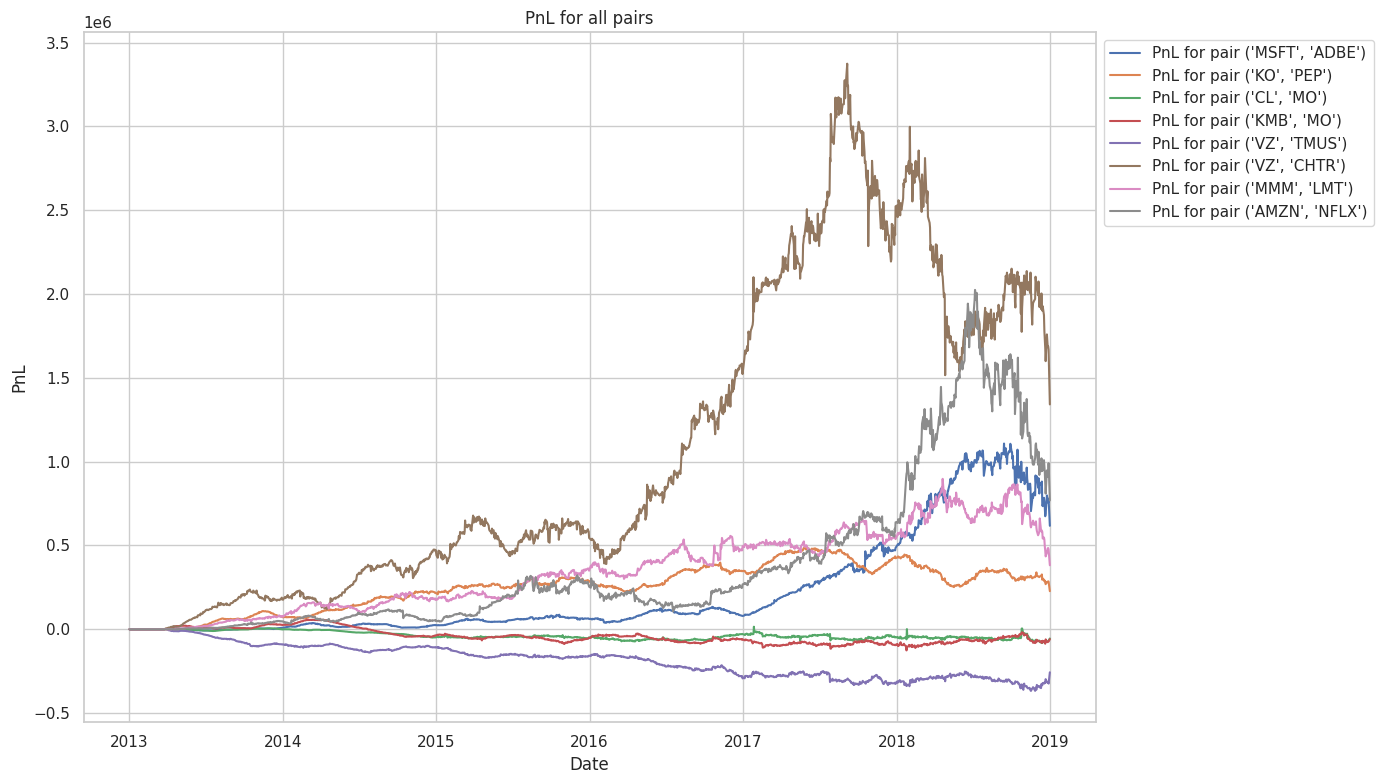

In [48]:
import matplotlib.pyplot as plt

# Plotting all PnL for each pair on the same chart
plt.figure(figsize=(14, 8))

for i in range(count):
    plt.plot(state_df.index, state_df['PnL_' + str(i)]*10, label=f'PnL for pair {pairs[i]}')

plt.title('PnL for all pairs')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

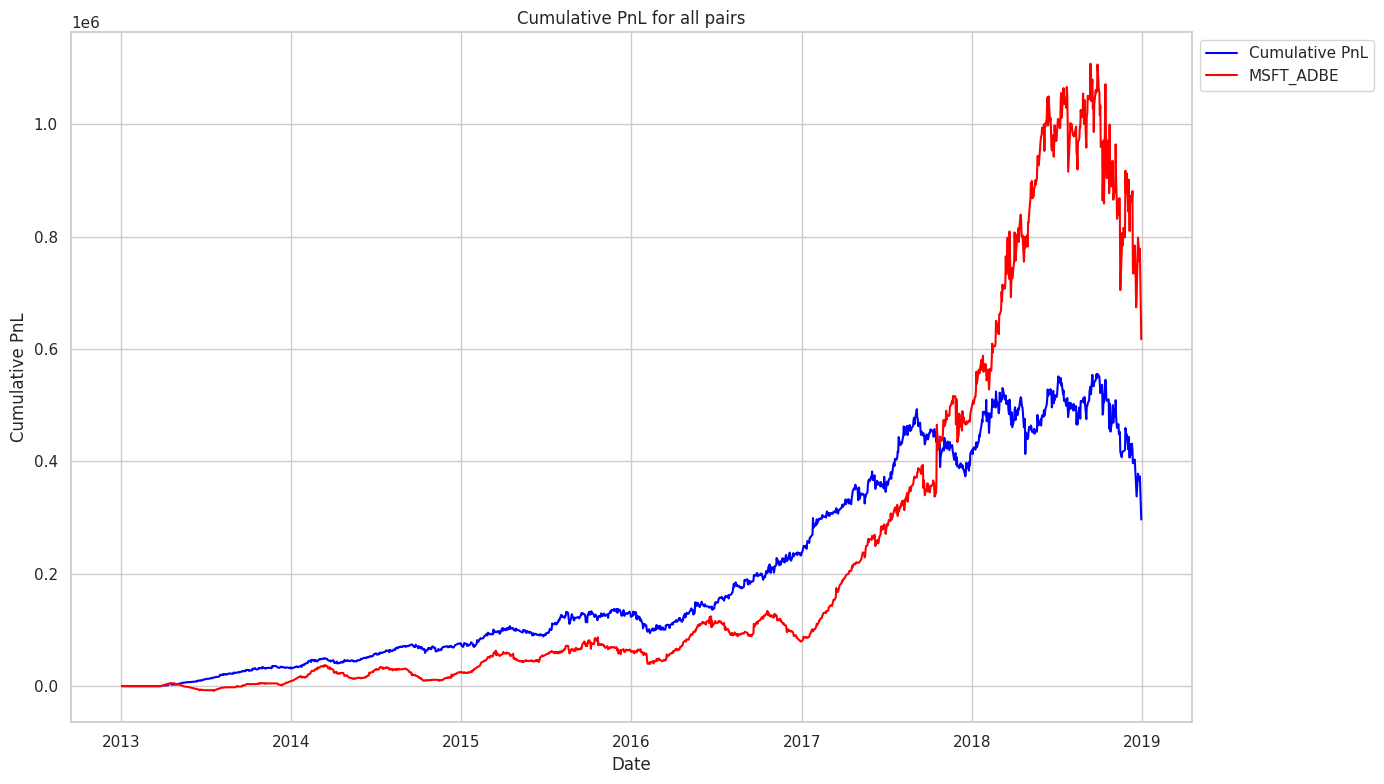

In [49]:
plt.figure(figsize=(14, 8))
plt.plot(state_df.index, state_df['cummulative_PnL'], label='Cumulative PnL', color='blue')
plt.plot(state_df.index, state_df['PnL_0']*10, label='MSFT_ADBE', color='red')
plt.title('Cumulative PnL for all pairs')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

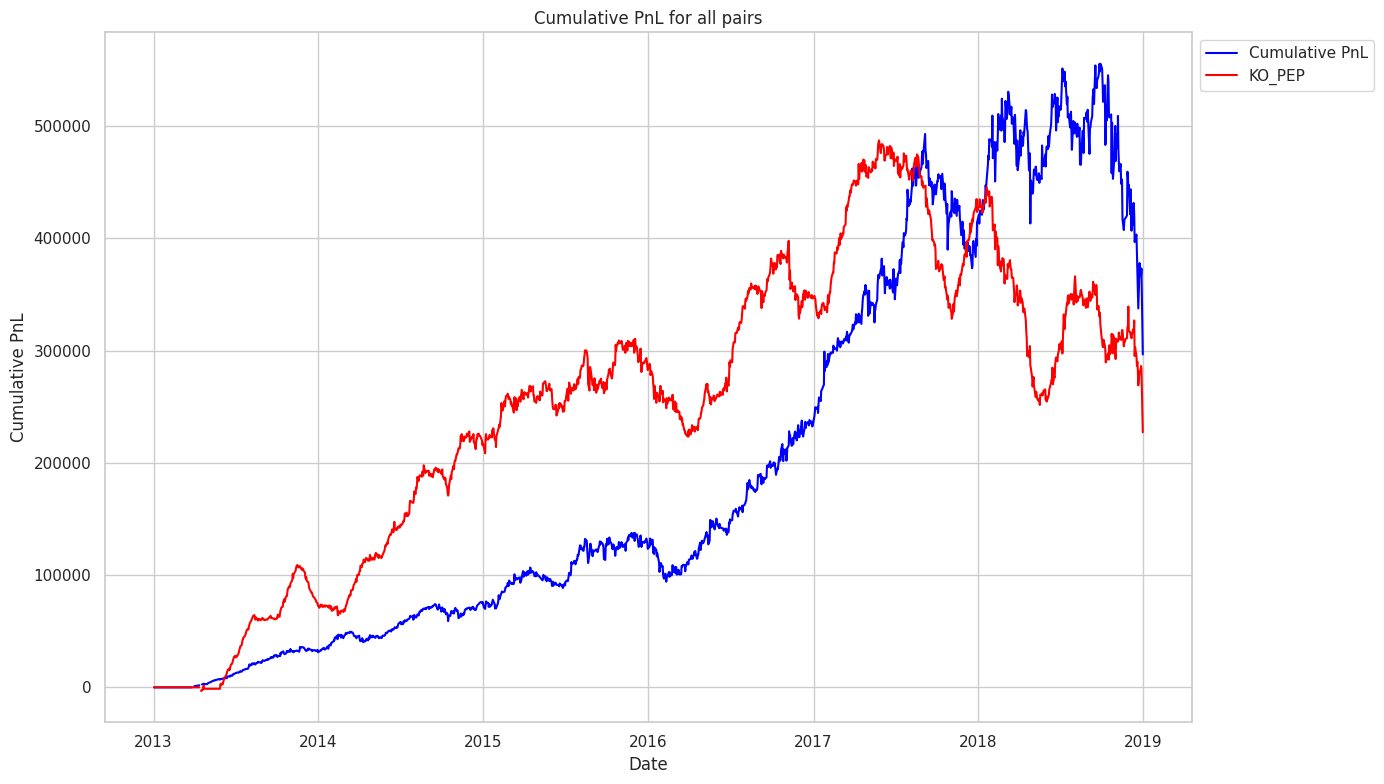

In [50]:
plt.figure(figsize=(14, 8))
plt.plot(state_df.index, state_df['cummulative_PnL'], label='Cumulative PnL', color='blue')
plt.plot(state_df.index, state_df['PnL_1']*10, label='KO_PEP', color='red')
plt.title('Cumulative PnL for all pairs')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [53]:
print(f"Final Profit: ${state_df['cummulative_PnL'][-1]:,.2f}")

Final Profit: $296,553.66


Finally we can see that using multiple pairs we do not get the best posssible returns which might be increased by changing parameters or chossing a single high performer. Despite slightly less returns we get much better volatality improvements giving the portfolio resistance against severe industry specific downturns.